# Evaluate models

In [ ]:
from pycisTopic.cistopic_class import *
from pycisTopic.lda_models import *

In [ ]:
models = pickle.load(open(os.path.join(out_dir, "models", cistopic_obj.project + '_models.pkl'), 'rb'))

In [ ]:
cistopic_obj = pickle.load(open(os.path.join(out_dir, cistopic_obj.project + '.pkl'), 'rb'))

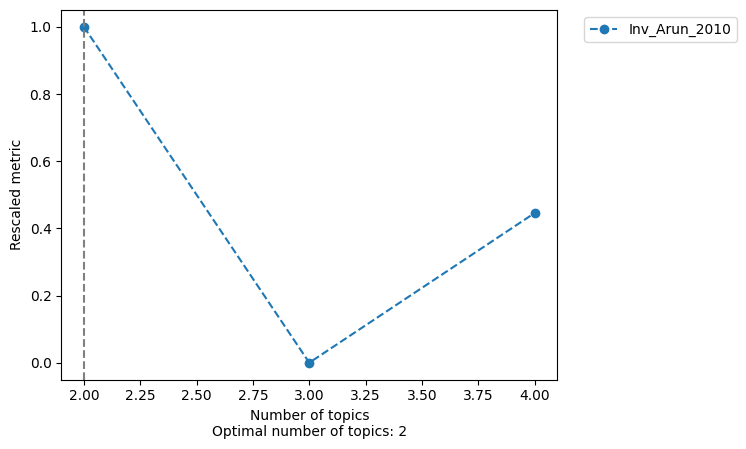

In [ ]:
model = evaluate_models(
    models,
    select_model=2,
    return_model=True,
    #metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
    metrics=['Arun_2010'],
    plot_metrics=False
)

In [ ]:
cistopic_obj.add_LDA_model(model)

In [ ]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, cistopic_obj.project + '_w_model.pkl'), 'wb')
)

In [ ]:
cistopic_obj

In [ ]:
from pycisTopic.clust_vis import *
run_umap(cistopic_obj, target  = 'cell', scale=True)

2023-04-19 11:21:24,239 cisTopic     INFO     Running UMAP


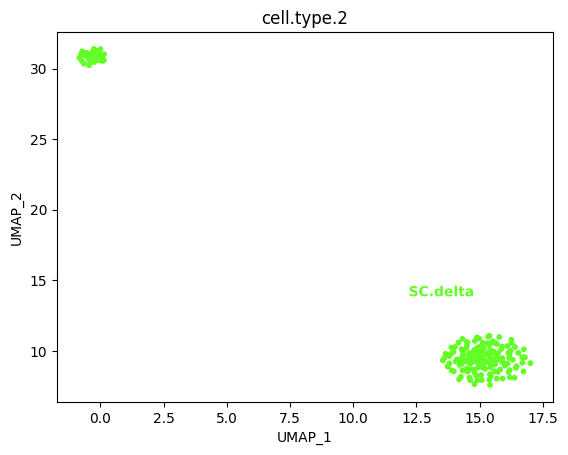

In [ ]:
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['cell.type.2'])

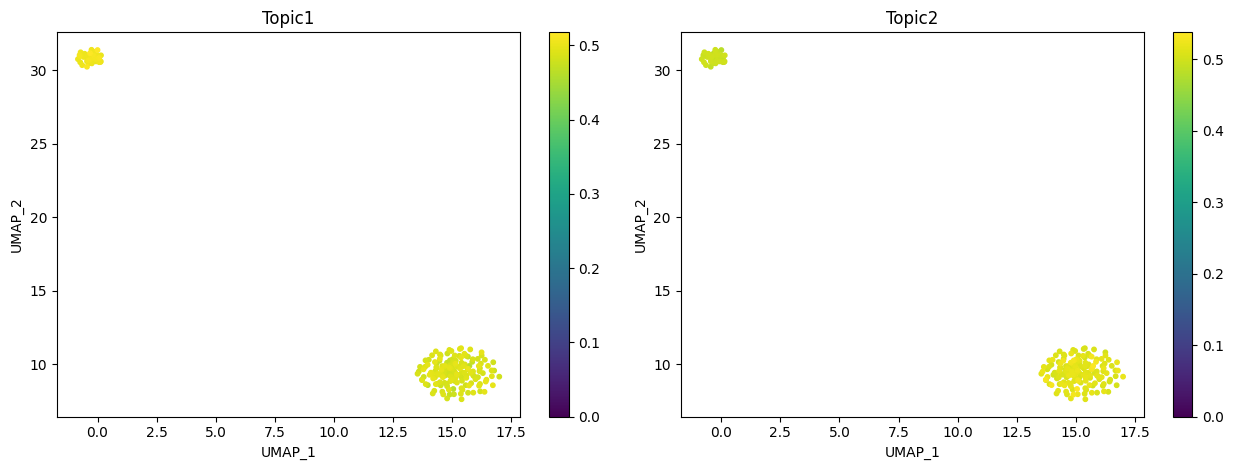

In [ ]:
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 2)

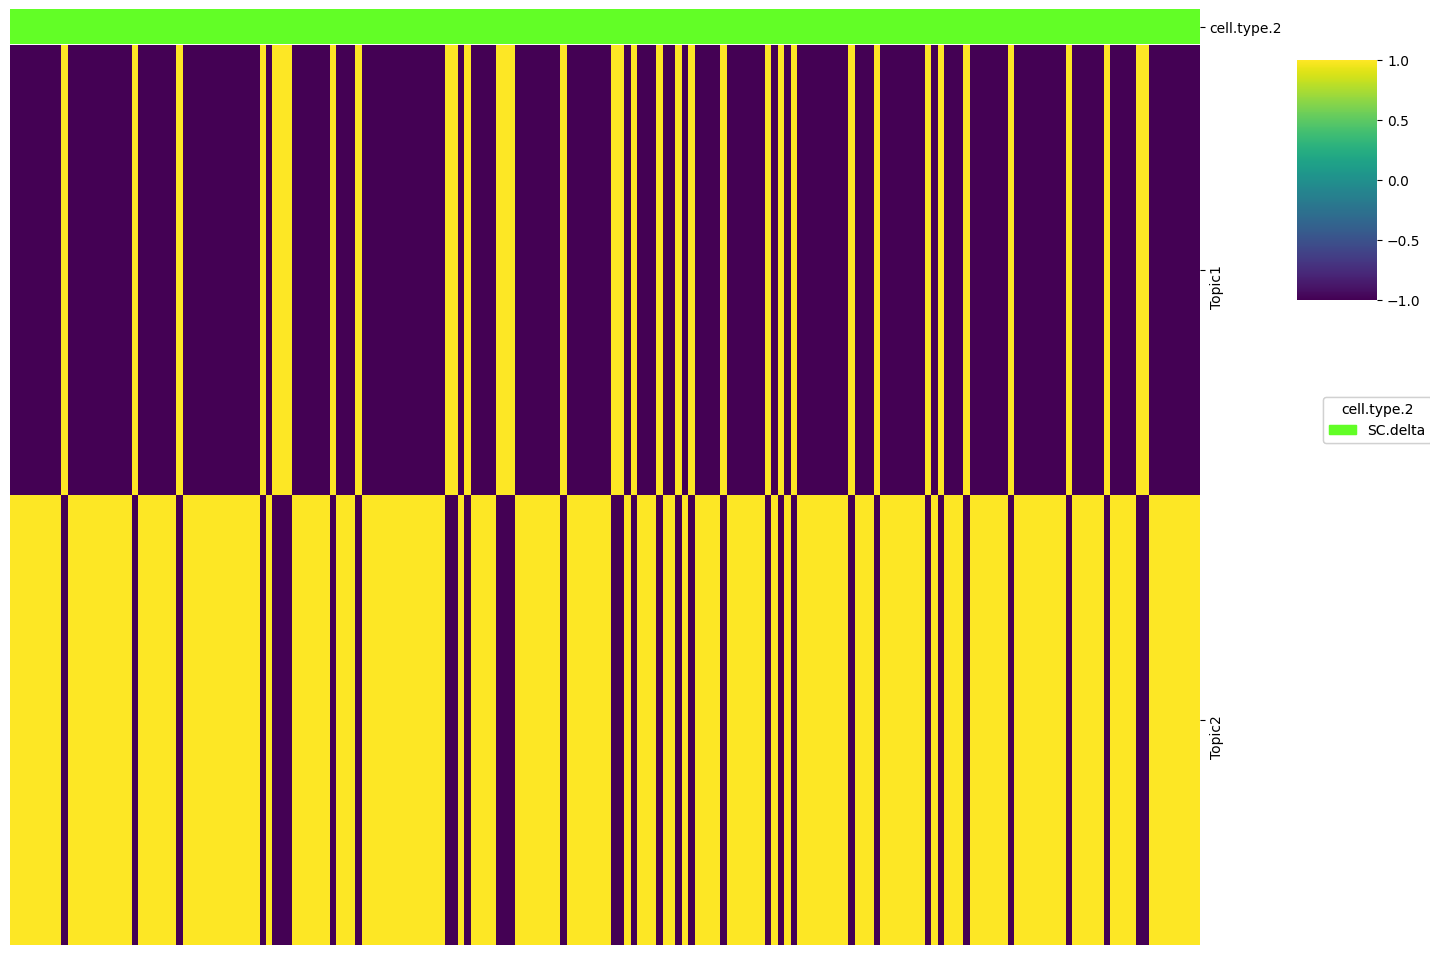

In [ ]:
cell_topic_heatmap(
    cistopic_obj=cistopic_obj, 
    variables = ['cell.type.2'], 
    cluster_topics=True, 
    scale=True, 
    figsize=(16, 12),
    legend_loc_x=1
)

# Binarize topics and save binarized matrix for model training

In [ ]:
cistopic_obj

In [ ]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')

<Figure size 640x480 with 0 Axes>

In [ ]:
region_data = cistopic_obj.region_data

In [ ]:
region_data_filt = region_data[region_data.index.str.contains("chr")]

In [ ]:
all_regions = region_data_filt.index

In [ ]:
topic_regions_pd = pd.Index([])
topic_regions_lst = []
topic_region_mp = {}
for topic, regions in region_bin_topics_otsu.items():
    topic_regions_lst += list(regions.index)
    topic_regions_pd = pd.Index.union(topic_regions_pd, regions.index)
    for region in regions.index:
        topic_region_mp.setdefault(region, []).append(topic)
topic_regions_np = np.array(topic_regions_lst)
topic_regions_set = set(topic_regions_lst)

In [ ]:
len(all_regions)

184106

In [ ]:
len(topic_regions_pd), len(topic_regions_lst), len(topic_regions_np), len(topic_regions_set)

(115585, 261885, 261885, 115585)

In [ ]:
topic_regions_pd.isin(all_regions).sum()

115585

In [ ]:
non_topic_regions = all_regions[~all_regions.isin(topic_regions_pd)]

In [ ]:
for topic, regions in region_bin_topics_otsu.items():
    print(non_topic_regions.isin(regions.index).sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
arr = np.zeros((len(all_regions), len(region_bin_topics_otsu)))
for i, row in enumerate(all_regions):
    if row in topic_region_mp:
        topic_nums = []
        for topic in topic_region_mp[row]:
            #print(i, row, topic, topic.split("Topic")[-1])
            topic_nums.append(int(topic.split("Topic")[-1])-1)
        arr[i, topic_nums] = 1

In [ ]:
arr.sum(axis=0)

array([19760.,  5930.,  5717.,  7917.,  9757., 13911.,  9812.,  6613.,
        5818.,  4880.,  5614.,  7100.,  8666.,  8277.,  2257.,  8470.,
        6736.,  9981., 10283.,  8087.,  6695.,  5166.,  6754.,  6411.,
        6258.,  8474.,  9600.,  4381.,  6441., 12577., 11977., 11565.])

In [ ]:
np.array([len(regions) for topic, regions in region_bin_topics_otsu.items()]) == arr.sum(axis=0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [ ]:
np.all(all_regions[arr.sum(axis=1) == 0].isin(non_topic_regions))

True

In [ ]:
np.all(~all_regions[arr.sum(axis=1) == 0].isin(topic_regions_pd))

True

In [ ]:
arr.sum() == len(topic_regions_lst)

True

In [ ]:
import pyranges

In [ ]:
pr_obj = pyranges.PyRanges(region_data_filt)

In [ ]:
seqs = pyranges.get_fasta(
    pr_obj, 
    "/cellar/users/aklie/projects/beta_cell_networks/bin/infer_grns/dictys/tutorial/data/genome/genome.fa"
)

In [ ]:
seqs.values[:5], len(seqs)

(array(['ctcttttctgttttgtggcattcctgcactgggatcttctgccacagaactgcttcatgagtttcctgtttttttcatttatgatgaactgtctggtcatgattccatcctgcttcacagacacatttCCCACAATTTCCTTAGAGAATATCCATGCAGTGATGGTCACCTTCTCTAACAGGCATTTCAGAGTGAGGTGGGACGTTCTAGGGCACCTGTTTTGCAGATGCCCTCAGGGTGGGGGAAGGGCAGCTTCCAGCCTTCCCAGTTCCAGCACTCTCTCCCCCAGCCGCTACCTGCATGTGAATCCCTGGGAGACCCCACAGCCCATGTCTCTGAGTAAAACTGGATCCAGGAAGCCCTTTGCTTTCAGTGGTCCTCCCTGGAACTTCTGCACTCTGCAAGCTGGAGTTGAACATCTGCGACTCAGCCTCTCAGTGCACAGGGTATGTGGGGCTCGACTTCTAGACCTGGCCCTGACGAGTGCTTTTGTTAGCCTG',
        'ACACTAAAACACACCAGTTGAGGGCACTGGCCAGAGATAAGATTAGGTTAAGGCCAAGCAAAGCTGAGAAGACCATTGTTAAAATTTCAATCCTGTTCCTTTATCTTTTCAAATTAACTGAATATTGTTATTAAATTTCTTGTTTTAGTGTCGaatagcaccttttccctgcctcactttagaatcaatttagagacaaaggattcaggccaactgaggtcatcagcattatcgctaataatagctggactggcggatgcgattcagattcacacaacaatggatttcctaatctgaatcctagactgagatgaagccagccagccgtaagcattgcttaataaccaaagcctccccagataggcttcttgccctacagcactgaagacatgaaagaaacagaccaaaatgTACAAATATCTTTTATTCCTCAAAGGAAAAAGAAGAGTTACACATGCCTGTTTCTCACCAATAAGAGG

In [ ]:
len(arr) == len(seqs)

True

In [ ]:
np.save(os.path.join(work_dir, "topics/labels"), arr)

In [ ]:
np.save(os.path.join(work_dir, "topics/seqs"), seqs)

In [ ]:
np.save(os.path.join(work_dir, "topics/regions"), all_regions.to_numpy())

# Find DARs

In [ ]:
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

In [ ]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='celltype', var_features=variable_regions, split_pattern = '-')

In [ ]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/candidate_enhancers')):
    os.makedirs(os.path.join(work_dir, 'scATAC/candidate_enhancers'))

In [ ]:
cistopic_obj pickle
pickle.dump(region_bin_topics_otsu, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(markers_dict, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'wb'))

# DONE!

---

# Scratch

## Create a pycisTopic object from R

In [ ]:
def load_cisTopic_model(path_to_cisTopic_model_matrices):
    metrics = None
    coherence = None
    marg_topic = None
    topic_ass = None
    cell_topic = pd.read_feather(path_to_cisTopic_model_matrices + "cell_topic.feather")
    cell_topic.index = ["Topic" + str(x) for x in range(1, cell_topic.shape[0] + 1)]
    topic_region = pd.read_feather(
            path_to_cisTopic_model_matrices + "topic_region.feather"
    )
    topic_region.index = ["Topic" + str(x) for x in range(1, topic_region.shape[0] + 1)]
    topic_region = topic_region.T
    parameters = None
    model = CistopicLDAModel(
            metrics, coherence, marg_topic, topic_ass, cell_topic, topic_region, parameters
    )
    return model


In [ ]:
model = load_cisTopic_model(os.path.join(work_dir, "model_to_pycisTopic/"))

In [ ]:
import pycisTopic
## 1. Initialize cisTopic object
from pycisTopic.cistopic_class import *
# Load count matrix
matrix_path=os.path.join(work_dir, 'model_to_pycisTopic/count_matrix.mtx')

In [ ]:
from scipy import io
fragment_matrix = io.mmread(os.path.join(matrix_path))
fragment_matrix = fragment_matrix.tocsr()

In [ ]:
cell_data = pd.read_csv(os.path.join(work_dir, 'model_to_pycisTopic/cell_data.tsv'), sep="\t")

In [ ]:
region_data = pd.read_csv(os.path.join(work_dir, 'model_to_pycisTopic/region_data.tsv'), sep="\t")

In [ ]:
cisTopic_from_R = create_cistopic_object(fragment_matrix=fragment_matrix, cell_names=cell_data.index, region_names=region_data.index, split_pattern="", project="")

2023-01-20 10:29:46,936 cisTopic     INFO     Creating CistopicObject
2023-01-20 10:29:55,699 cisTopic     INFO     Done!


In [ ]:
# Also add the cell annotation, cell_data should be a pandas df with cells as rows (cell names as index) and variables as columns
cisTopic_from_R.add_cell_data(cell_data)

In [ ]:
cisTopic_from_R.add_LDA_model(model)

In [ ]:
pickle.dump(
    cisTopic_from_R,
    open(os.path.join(work_dir, 'cistopic_obj_fromR_model.pkl'), 'wb')
)

## Eval that object

In [ ]:
cisTopic_from_R = pickle.load(open(os.path.join(work_dir, 'cistopic_obj_fromR_model.pkl'), 'rb'))

2023-02-02 08:35:06,181 cisTopic     INFO     Running UMAP


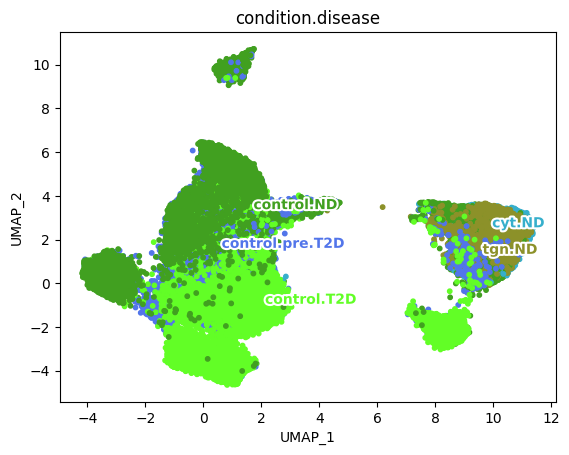

In [ ]:
from pycisTopic.clust_vis import *
run_umap(cisTopic_from_R, target  = 'cell', scale=True)
plot_metadata(cisTopic_from_R, reduction_name = 'UMAP', variables = ['condition.disease'])

/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


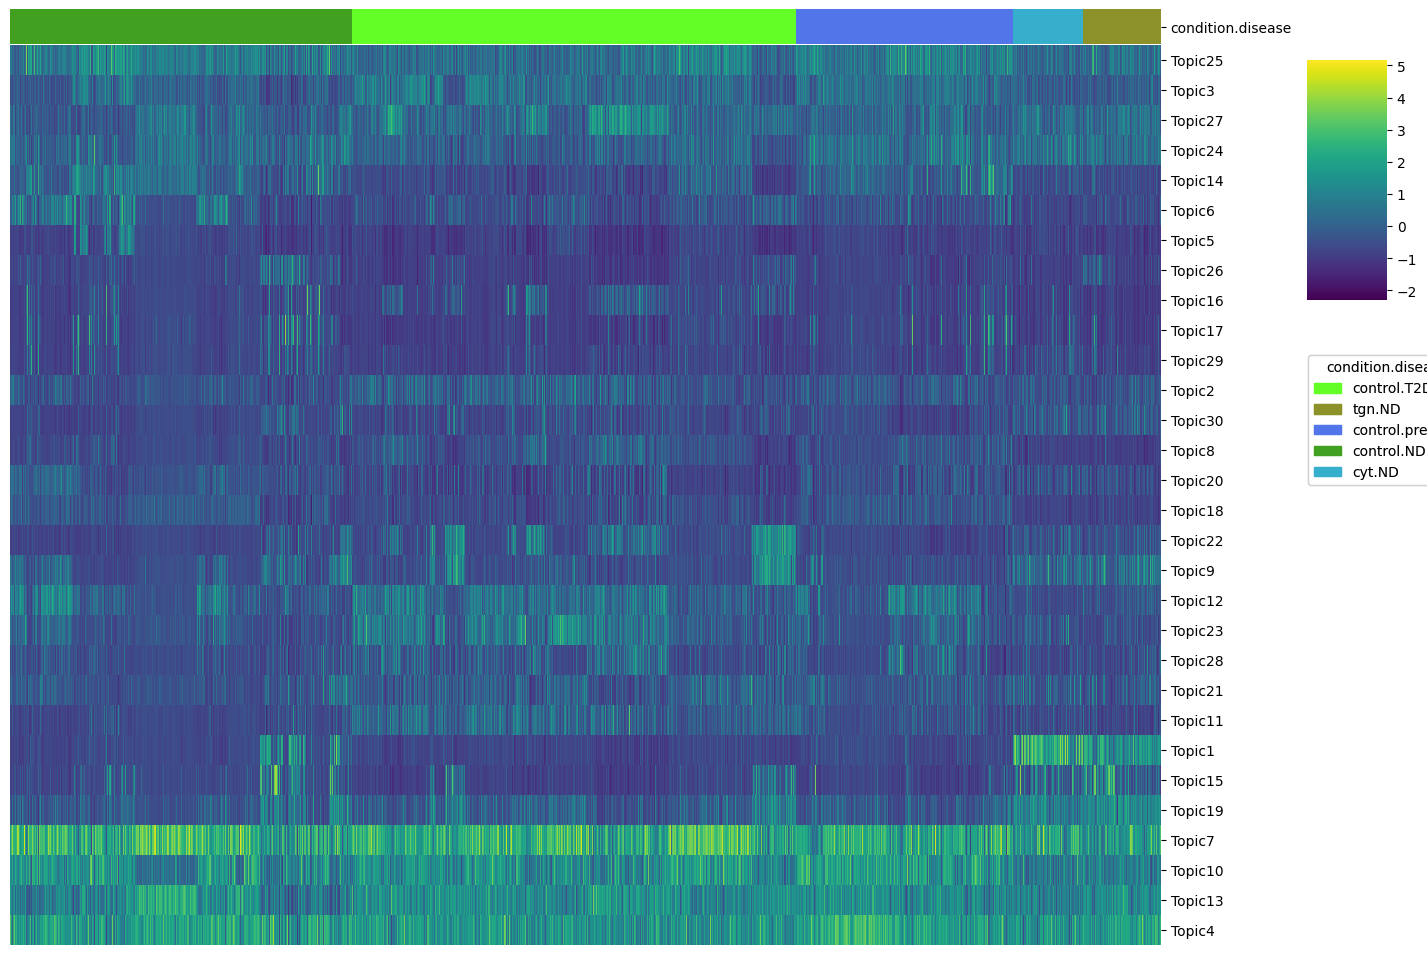

In [ ]:
cell_topic_heatmap(
    cistopic_obj=cisTopic_from_R, 
    variables = ['condition.disease'], 
    cluster_topics=True, 
    scale=True, 
    figsize=(16, 12),
    legend_loc_x=1
)

## Binarize the topics

In [ ]:
from pycisTopic.topic_binarization import *

In [ ]:
cisTopic_from_R.selected_model.topic_ass = {}

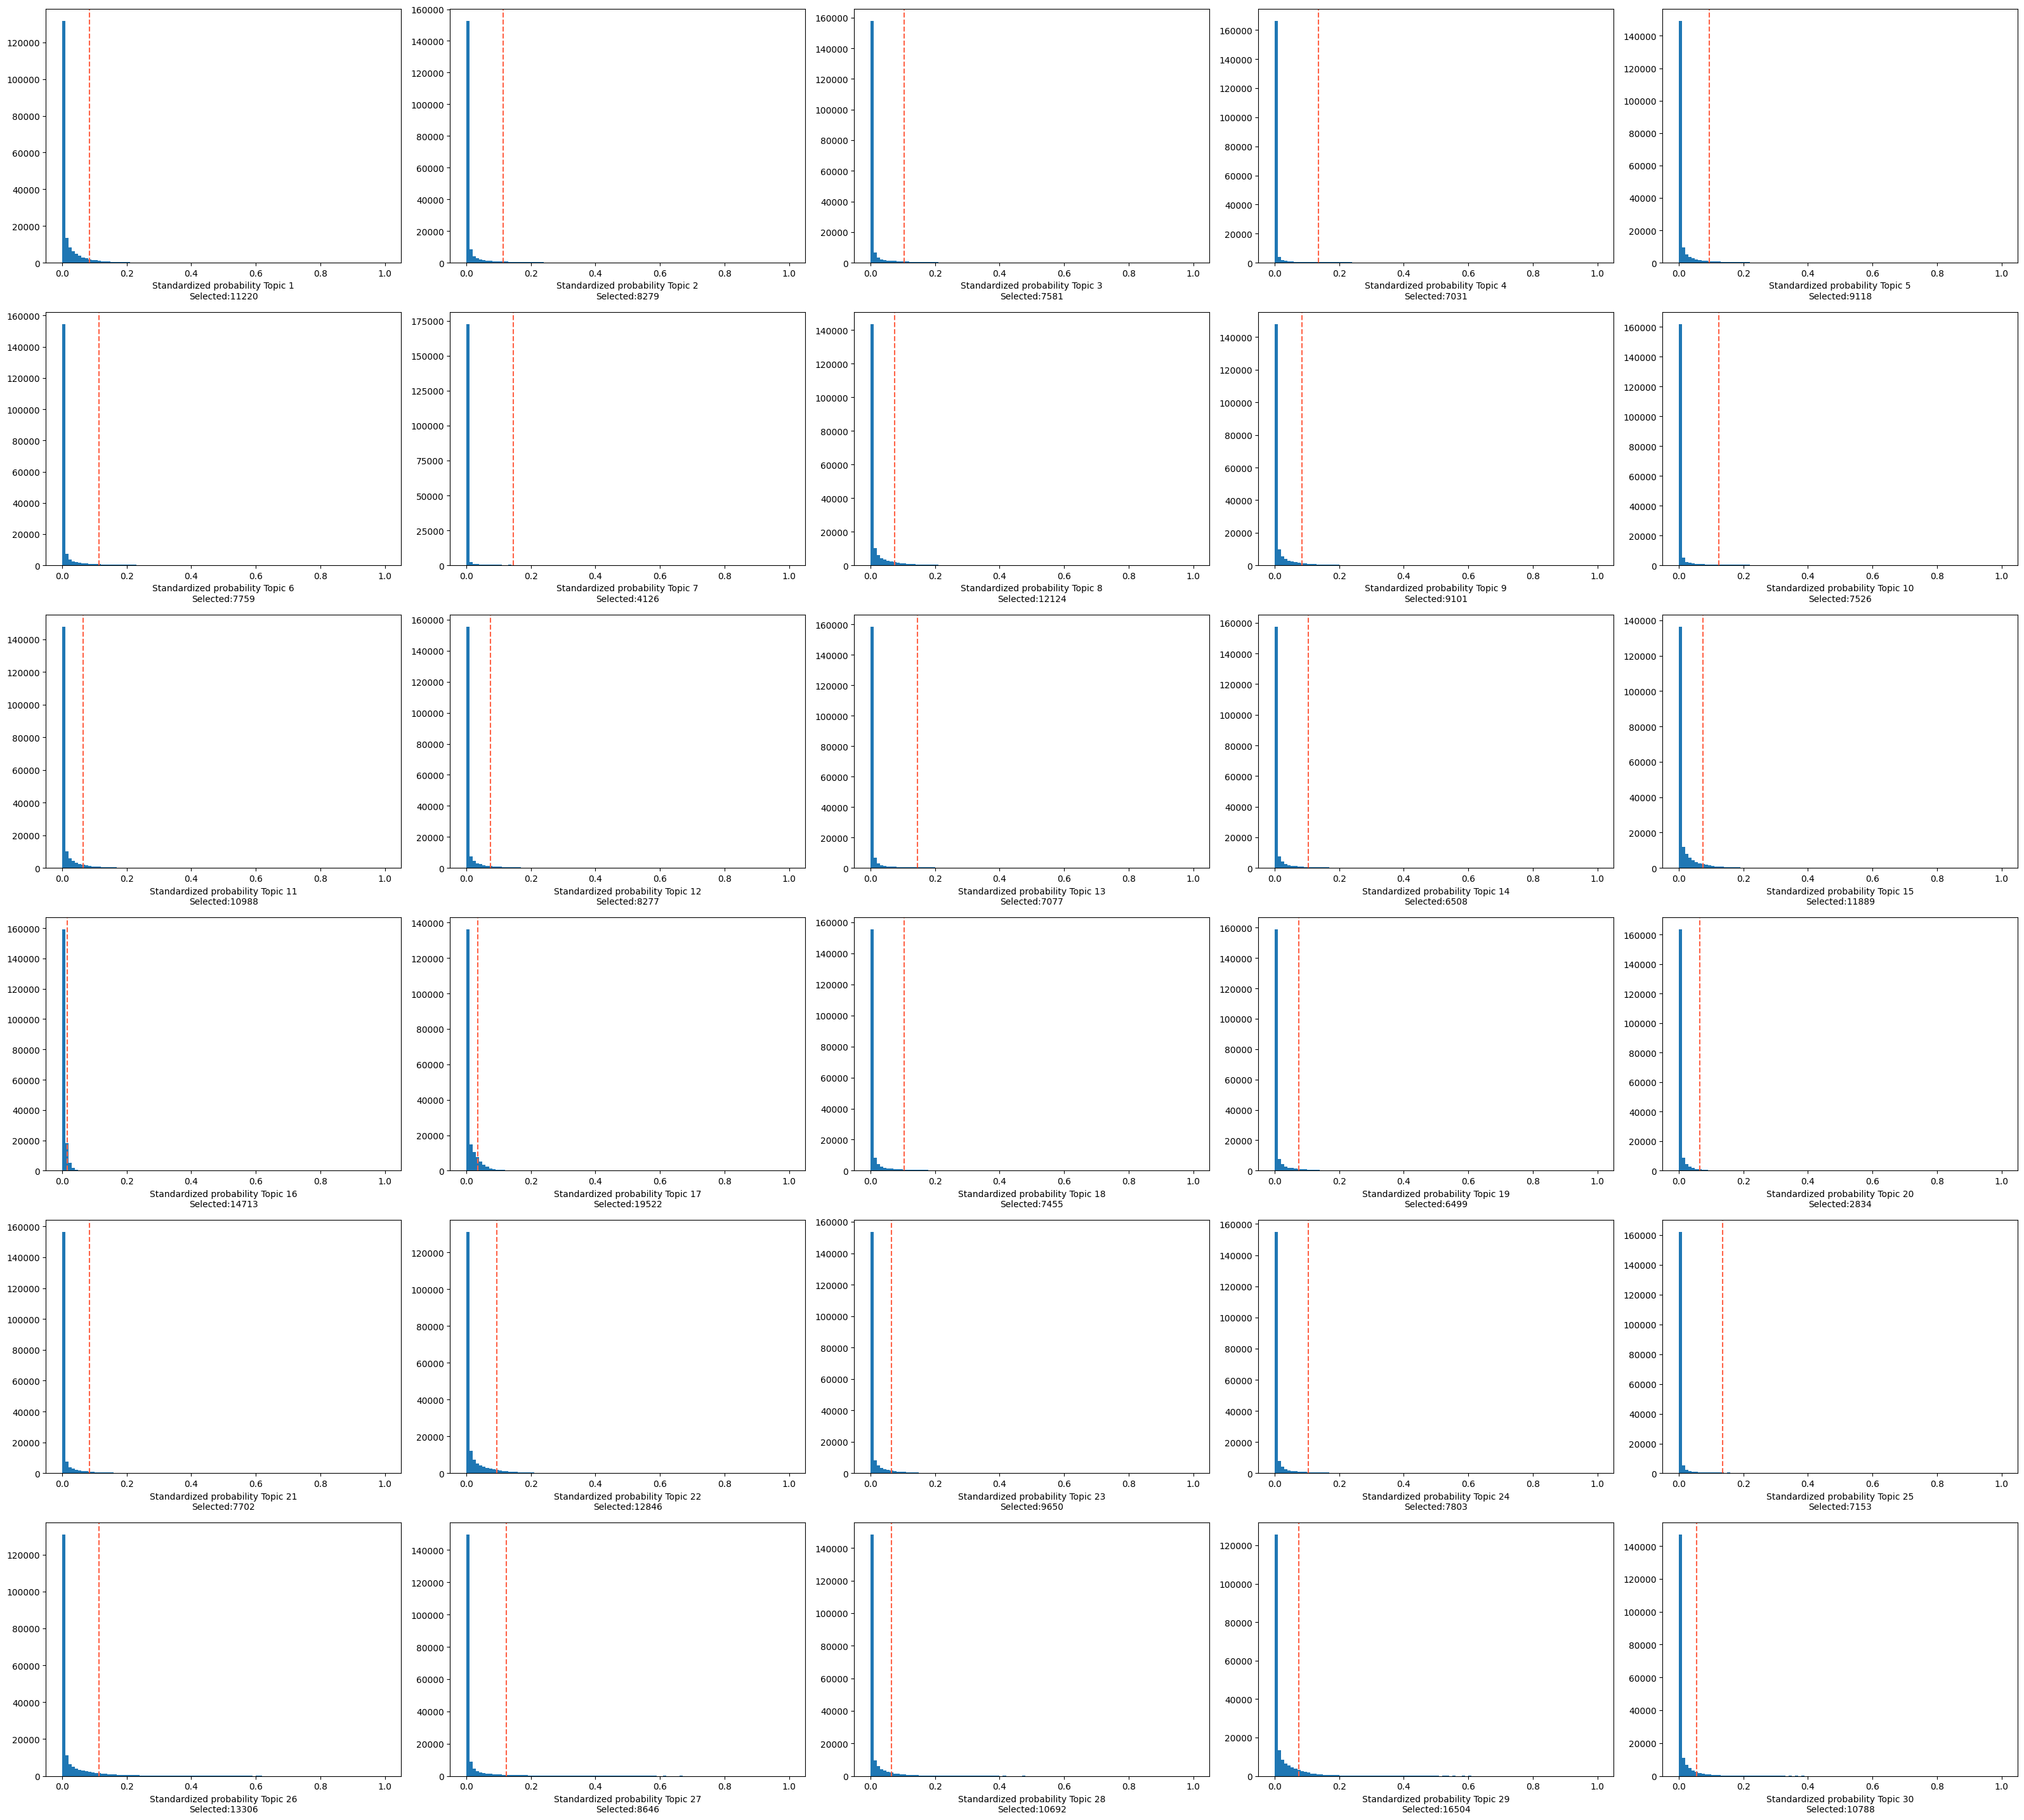

In [ ]:
region_bin_topics = binarize_topics(cisTopic_from_R, method='otsu', ntop=3000, plot=True, num_columns=5)

In [ ]:
cisTopic_from_R.selected_model.topic_ass = {}

In [ ]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cisTopic_from_R, method='otsu')

<Figure size 640x480 with 0 Axes>

In [ ]:
region_data = cisTopic_from_R.region_data

In [ ]:
region_data_filt = region_data[region_data.index.str.contains("chr")]

In [ ]:
all_regions = region_data_filt.index

In [ ]:
topic_regions_pd = pd.Index([])
topic_regions_lst = []
topic_region_mp = {}
for topic, regions in region_bin_topics_otsu.items():
    topic_regions_lst += list(regions.index)
    topic_regions_pd = pd.Index.union(topic_regions_pd, regions.index)
    for region in regions.index:
        topic_region_mp.setdefault(region, []).append(topic)
topic_regions_np = np.array(topic_regions_lst)
topic_regions_set = set(topic_regions_lst)

In [ ]:
len(all_regions)

185580

In [ ]:
len(topic_regions_pd), len(topic_regions_lst), len(topic_regions_np), len(topic_regions_set)

(109777, 284717, 284717, 109777)

In [ ]:
topic_regions_pd.isin(all_regions).sum()

109777

In [ ]:
non_topic_regions = all_regions[~all_regions.isin(topic_regions_pd)]

In [ ]:
for topic, regions in region_bin_topics_otsu.items():
    print(non_topic_regions.isin(regions.index).sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
arr = np.zeros((len(all_regions), len(region_bin_topics_otsu)))
for i, row in enumerate(all_regions):
    if row in topic_region_mp:
        topic_nums = []
        for topic in topic_region_mp[row]:
            #print(i, row, topic, topic.split("Topic")[-1])
            topic_nums.append(int(topic.split("Topic")[-1])-1)
        arr[i, topic_nums] = 1

In [ ]:
arr.sum(axis=0)

array([11220.,  8279.,  7581.,  7031.,  9118.,  7759.,  4126., 12124.,
        9101.,  7526., 10988.,  8277.,  7077.,  6508., 11889., 14713.,
       19522.,  7455.,  6499.,  2834.,  7702., 12846.,  9650.,  7803.,
        7153., 13306.,  8646., 10692., 16504., 10788.])

In [ ]:
np.array([len(regions) for topic, regions in region_bin_topics_otsu.items()]) == arr.sum(axis=0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [ ]:
np.all(all_regions[arr.sum(axis=1) == 0].isin(non_topic_regions))

True

In [ ]:
np.all(~all_regions[arr.sum(axis=1) == 0].isin(topic_regions_pd))

True

In [ ]:
arr.sum() == len(topic_regions_lst)

True

In [ ]:
import pyranges

In [ ]:
pr_obj = pyranges.PyRanges(region_data_filt)

In [ ]:
seqs = pyranges.get_fasta(
    pr_obj, 
    "/cellar/users/aklie/projects/beta_cell_networks/bin/infer_grns/dictys/tutorial/data/genome/genome.fa"
)

In [ ]:
seqs.values[:5], len(seqs)

(array(['NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNtaaccctaaccctaaccctaaccctaaccctaaccctaaccctaaccctaaccctaaccctaaccctaaccctaaccctaaccctaaccctaaccctaaccctaacccaaccctaaccctaaccctaaccctaaccctaaccctaacccctaaccctaaccctaaccctaaccctaacctaaccctaaccctaaccctaaccctaaccctaaccctaaccctaaccctaacccctaaccctaaccctaaaccctaaaccctaaccctaaccctaaccctaaccctaaccccaaccccaaccccaaccccaaccccaaccccaaccctaacccctaaccctaaccctaaccctacc',
        'TAAGGGGCCCAACAGCCTTGACTGGAGAGGAGCTCTGGCAAGGCCCTGGGCCACTGCACCTGTCTCCACCTCTGTCCCACCCCTCCCACCTGCTGTTCCAGCTGCTCTCTCTTGCTGATGGACAAGGGGGCATCAAACAGCTTCTCCTCTGTCTCTGCCCCCAGCATCACATGGGTCTTTGTTACAGCACCAGCCAGGGGGTCCAGGAAGACATACTTCTTCTACCTACAGAGGCGACATGGGGGTCAGGCAAGCTGACACCCGCTGTCCTGAGCCCATGTTCCTCTCCCACATCATCAGGGGCACAGCGTGCACTGTGGGGTCCCAGGCCTCCCGAGCCGAGCCACCCGTCACCCCCTGGCTCCTGGCCTATGTGCTGTACCTGTGTCTGATGCCCTGGGTCCCCACTAAGCCAGGCCGGGCCTCCCGCCCACACCCCTCGGCCCTGCCCTCTGGCCATACAGGTTCTCGGTGGTGTT

In [ ]:
len(arr) == len(seqs)

True

In [ ]:
np.save(os.path.join(work_dir, "topics/labelsR"), arr)

In [ ]:
np.save(os.path.join(work_dir, "topics/seqsR"), seqs)

In [ ]:
np.save(os.path.join(work_dir, "topics/regionsR"), all_regions.to_numpy())